### Importing modules

In [1]:
#Importing modules and font style
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['lines.linewidth']=3
plt.rcParams['lines.markersize']=10

### Functions 

In [2]:
def energy_afmtip(results_file_path):
    """
    Read energy and distances from Pygbe results file, for 
    a afm-tip example
    -------
    Inputs:
        results_file_path: Pygbe results file
    Return:
        None
    """
    results_file = open(results_file_path,'r')
    results_data = results_file.read().split('\n')
    for line in results_data:
        if 'Surface 0' in line:
            surf = 0
        elif 'Surface 1' in line:
            surf = 1
        elif 'box center' in line:
            aux = line.split(': ')
            if surf == 0:
                line = aux[1].split(',')
                r_surf1 = np.array([float(line[0]),float(line[1]),float(line[2])])
            elif surf == 1:
                line = aux[1].split(',')
                r_surf2 = np.array([float(line[0]),float(line[1]),float(line[2])])
    aux = results_data[-6].split('= ')
    E_solv = float(aux[1].split(' ')[0])
    aux = results_data[-5].split('= ')
    E_surf = float(aux[1].split(' ')[0])
    aux = results_data[-4].split('= ')
    E_coul = float(aux[1].split(' ')[0])
    results_file.close()
    
    return r_surf1, r_surf2, E_solv, E_surf, E_coul

def readpqr(filename, N):
    """
    Read pqr-format file
    -------
    Inputs:
        filename: file .pqr with point-charge-radius format
        N: number of solute charges present in filename
    Return:
        position: Array size (Nx3) with charges positions
        q: Array size (Nx1) with charges values
        amino_acid_name: Array (Nx1) with charges amino acid name
        amino_acid_number: Array (Nx1) with charges amino acid name 
        atom_name: Array (Nx1) with atom_names
        atom_number: Array (Nx1) with atom_numbers  
    """
    pqr_file = open(filename,'r')
    position = np.zeros((N,3))
    q = np.zeros(N)
    amino_acid_name = np.array(q, dtype=np.string_)
    atom_name = np.array(q, dtype=np.string_)
    chain = np.array(q, dtype=np.string_)
    amino_acid_number = np.zeros(N, dtype=int)
    counter = 0
    for i, line in enumerate(pqr_file):
        line_split = line.split()
        if line_split[0] == 'ATOM':
            position[counter,0] = float(line_split[6])
            position[counter,1] = float(line_split[7])
            position[counter,2] = float(line_split[8])
            q[counter] = float(line_split[9])
            amino_acid_name[counter] = line_split[3]
            amino_acid_number[counter] = int(line_split[5])
            atom_name[counter] = line_split[2]
            chain[counter] = line_split[4]
            counter += 1
        
    return position, q, amino_acid_name, amino_acid_number, atom_name,chain

def compute_force_fixedcharge(dphi, q, units='kcal'):
    """
    Compute forces due solute charges in the solute
    from dphi.txt file and q charges array
    -------
    Inputs:
        dphi: file .pqr with point-charge-radius format
        q: number of solute charges present in filename
    Return:
        force: Array size (Nx3) with forces for solute charges
        force_magnitude: Array size (Nx1) with forces magnitude for solute charges 
        total_force: Array size (1x3) with total force due solute charges
        total_force_magnitude: Array (1x1) with total force magnitude
    """
    if units == 'kcal':
        factor = 4*np.pi*332.0636817823836 #1e-3*Na*1e10*(qe**2/(ep_vacc*4*numpy.pi*cal2J))
    elif units == 'kJ':
        factor = 4.184*4*np.pi*332.0636817823836
    elif units == 'pN':
        factor = 69.467*4*np.pi*332.0636817823836
        
    force = -np.transpose(np.transpose(dphi)*q)
    force_magnitude = np.sqrt(np.sum(force**2, axis=1))
    total_force = np.sum(force, axis=0)
    total_force_magnitude = np.sqrt(np.sum(total_force**2))

    return factor*force, factor*force_magnitude, factor*total_force, factor*total_force_magnitude

def forces_fixedcharge_zika(dir):
    """
    Read from directory with results file to get 
    fixed charge forces for afm-zika case
    -------
    Inputs:
        dir: directory with results file
        distance: afm to tip distance between centres
    Return:
        fqf: Array size (1x3) with total force due solute charges
        fqf_mag: Array (1x1) with total force magnitude
    """    
    zatsc_folders = glob.glob(dir+'/*zatsc*') # Search distances availables in zatsc folders
    zatsc_folders.sort(key=lambda x: int(x.split('zatsc')[-1])) # Sort by distance
    fqf = np.zeros((len(zatsc_folders),3))
    fqf_mag = np.zeros(len(zatsc_folders))
    dist = np.array([])
    for j in range(len(zatsc_folders)):
        distance = int(zatsc_folders[j].split('zatsc')[-1]) # Get distance
        dist = np.append(dist, distance)
        dir_dphir = dir + '\\zatsc' + str(distance) + '\\dphir.txt'
        dphir = np.loadtxt(dir_dphir)
        _, q, _, _, _,_ = readpqr('zika_afm\\ZIKV_6CO8_aa_charge_vdw_addspace.pqr',len(dphir))
        _, _, fqf[j,:], fqf_mag[j] = compute_force_fixedcharge(dphir,q)

    return dist, fqf, fqf_mag

def boundary_forces_zika(distances, boundary_forces_file):
    
    fdb = np.zeros([len(distances),3])
    fib = np.zeros([len(distances),3])
    d = np.zeros([len(distances),1])
    to_kcalmolA = 4*np.pi*332.0636817823836
    f_boundary = np.loadtxt(str(boundary_forces_file),delimiter=' ')
    for j in range(len(f_boundary)):
        d[j] = f_boundary[j,0]
        fdb[j] =to_kcalmolA*f_boundary[j,1:4]
        fib[j] =to_kcalmolA*f_boundary[j,4:]

    return d, fdb, fib

### Load simulation files

In [3]:
# Fixed charge force calculation with dphir file from Pygbe
dist,fqf,_ = forces_fixedcharge_zika('zika_afm\\tip_charge-2.5_rad150')
dist_cono,fqf_cono,_ = forces_fixedcharge_zika('zika_afm\\sysBunchAnalysisCones')
dist_cono_lls, fqf_cono_lls,_ = forces_fixedcharge_zika('zika_afm\\sysBunchAnalysisConesLSalt20mM')

# Boundary force from Pygbe calculation
d,fdb,fib = boundary_forces_zika(dist,'zika_afm\\boundary_forces_results\\boundary_forces_zika.txt')
d_cono,fdb_cono,fib_cono = boundary_forces_zika(dist_cono,'zika_afm\\boundary_forces_results\\boundary_forces_zika_cono.txt')
d_cono_lls, fdb_cono_lls, fib_cono_lls = boundary_forces_zika(dist_cono_lls,'zika_afm\\boundary_forces_results\\boundary_forces_zika_cono_salino20mM.txt')

# Binding force by substracting solvation force for capsid far away from tip
F_terms = 69.467*(fqf[:]+fdb[:]+fib[:]-fqf[-1]-fdb[-1]-fib[-1])
F_terms_cono = 69.467*(fqf_cono[:]+fdb_cono[:]+fib_cono[:]-fqf_cono[-1]-fdb_cono[-1]-fib_cono[-1])
F_terms_cono_lls = 69.467*(fqf_cono_lls[:]+fdb_cono_lls[:]+fib_cono_lls[:]-fqf_cono_lls[-1]-fdb_cono_lls[-1]-fib_cono_lls[-1])

# MVM fitting function (Podgornik et al. Nanoscale, 2015)
def forces_MVM(d,B,A=0,k=1/6.8):
    return (A*np.exp(-2*k*d)+B*np.exp(-k*d))/(1-np.exp(-2*k*d))

In [4]:
#Distances from tip to afm in Angstrom
d = dist -384 
d_cono = dist_cono -384 
d_cono_lls = dist_cono_lls - 384 
dd = np.arange(394,434,0.1)

### Plot Capsid-Sphere $\kappa=0.125$ 

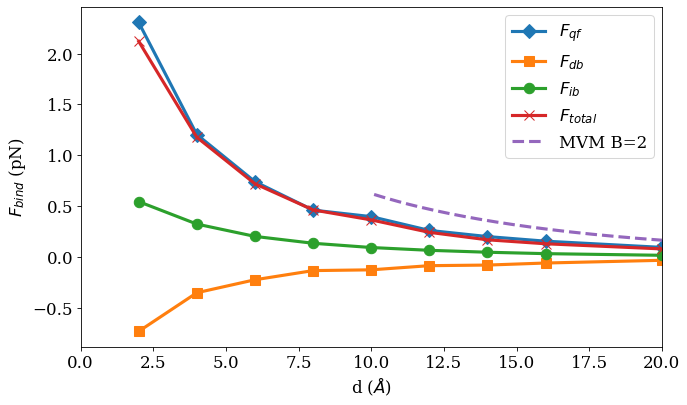

In [5]:
delta_fqf = 69.467*(fqf.swapaxes(0,1)[0]-fqf.swapaxes(0,1)[0][-1])
delta_fdb = 69.467*(fdb.swapaxes(0,1)[0]-fdb.swapaxes(0,1)[0][-1])
delta_fib = 69.467*(fib.swapaxes(0,1)[0]-fib.swapaxes(0,1)[0][-1])

plt.figure(figsize=(10,6),dpi=75)
plt.plot(d,-delta_fqf, marker='D',label='$F_{qf}$')
plt.plot(d,-delta_fdb, marker='s',label='$F_{db}$')
plt.plot(d,-delta_fib, marker='o',label='$F_{ib}$')
plt.plot(d,-F_terms.swapaxes(0,1)[0], marker='x',label='$F_{total}$')
plt.plot(dd[1:]-384,forces_MVM(dd[1:]-384,2,k=0.125),label='MVM B=2',linestyle='--')
plt.xlim([0,20])
plt.xlabel('d ($\AA$)');
plt.ylabel('$F_{bind}$ (pN)')
plt.legend()
plt.savefig('plots\\Binding_forces_components_capsid_2_sphere.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Plot Capsid-Cone $\kappa = 0.125$

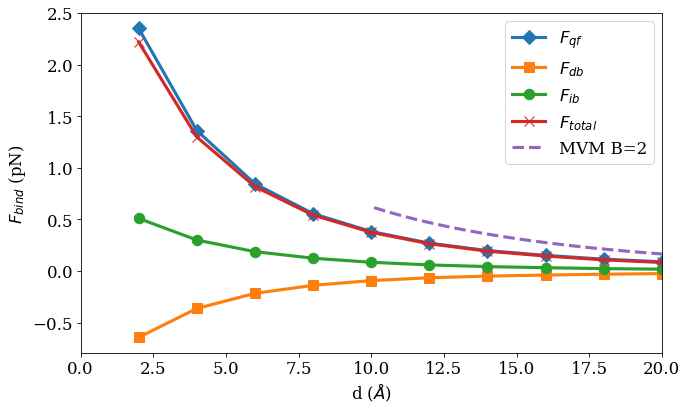

In [6]:
delta_fqf_cono = 69.467*(fqf_cono.swapaxes(0,1)[0]-fqf_cono.swapaxes(0,1)[0][-1])
delta_fdb_cono = 69.467*(fdb_cono.swapaxes(0,1)[0]-fdb_cono.swapaxes(0,1)[0][-1])
delta_fib_cono = 69.467*(fib_cono.swapaxes(0,1)[0]-fib_cono.swapaxes(0,1)[0][-1])

plt.figure(figsize=(10,6),dpi=75)
plt.plot(d_cono,-69.467*fqf_cono.swapaxes(0,1)[0]+69.467*fqf_cono.swapaxes(0,1)[0][-1], marker='D',label='$F_{qf}$')
plt.plot(d_cono,-69.467*fdb_cono.swapaxes(0,1)[0]+69.467*fdb_cono.swapaxes(0,1)[0][-1], marker='s',label='$F_{db}$')
plt.plot(d_cono,-69.467*fib_cono.swapaxes(0,1)[0]+69.467*fib_cono.swapaxes(0,1)[0][-1], marker='o',label='$F_{ib}$')
plt.plot(d_cono,-F_terms_cono.swapaxes(0,1)[0], marker='x',label='$F_{total}$')
plt.plot(dd[1:]-384,forces_MVM(dd[1:]-384,2,k=0.125),label='MVM B=2',linestyle='--')
plt.xlim([0,20])
plt.xlabel('d ($\AA$)');
plt.ylabel('$F_{bind}$ (pN)')
plt.legend()
plt.savefig('plots\\Binding_forces_components_capsid_2_cono.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Plot Capsid-Cone 20mM ($\kappa = 0.046$)

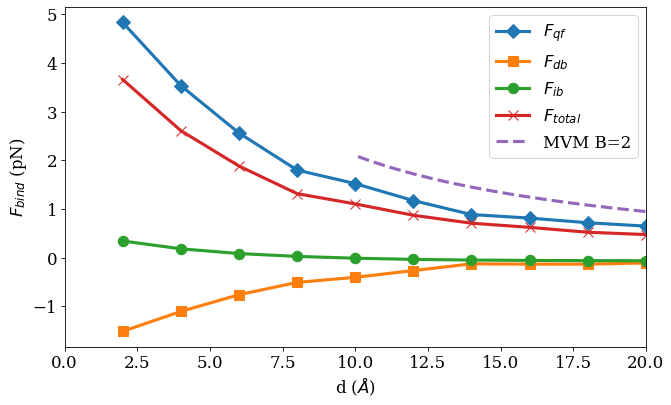

In [7]:
delta_fqf_cono_lls = 69.467*(fqf_cono_lls.swapaxes(0,1)[0]-fqf_cono_lls.swapaxes(0,1)[0][-1])
delta_fdb_cono_lls = 69.467*(fdb_cono_lls.swapaxes(0,1)[0]-fdb_cono_lls.swapaxes(0,1)[0][-1])
delta_fib_cono_lls = 69.467*(fib_cono_lls.swapaxes(0,1)[0]-fib_cono_lls.swapaxes(0,1)[0][-1])

plt.figure(figsize=(10,6),dpi=75)
plt.plot(d_cono_lls,-delta_fqf_cono_lls, marker='D',label='$F_{qf}$')
plt.plot(d_cono_lls,-delta_fdb_cono_lls, marker='s',label='$F_{db}$')
plt.plot(d_cono_lls,-delta_fib_cono_lls, marker='o',label='$F_{ib}$')
plt.plot(d_cono_lls,-F_terms_cono_lls.swapaxes(0,1)[0], marker='x',label='$F_{total}$')
plt.plot(dd[1:]-384,forces_MVM(dd[1:]-384,2,k=0.046),label='MVM B=2',linestyle='--')
plt.xlim([0,20])
plt.xlabel('d ($\AA$)');
plt.ylabel('$F_{bind}$ (pN)')
plt.legend()
plt.savefig('plots\\Binding_forces_components_capsid_2_cono_mM20.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Plot Cone vs Sphere

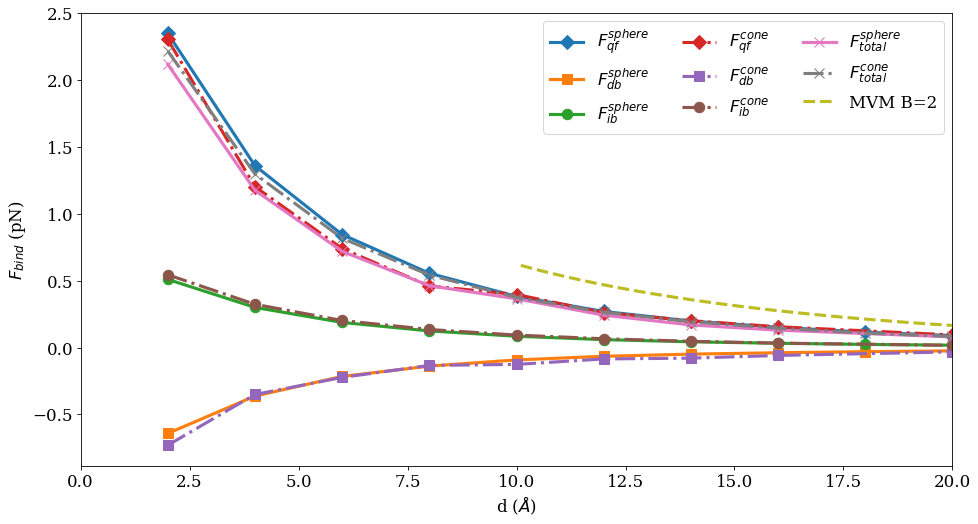

In [8]:
plt.figure(figsize=(15,8),dpi=75)
plt.plot(d_cono,-delta_fqf_cono, marker='D',label='$F_{qf}^{sphere}$')
plt.plot(d_cono,-delta_fdb_cono, marker='s',label='$F_{db}^{sphere}$')
plt.plot(d_cono,-delta_fib_cono, marker='o',label='$F_{ib}^{sphere}$')
plt.plot(d,-delta_fqf, marker='D',label='$F_{qf}^{cone}$',linestyle = '-.')
plt.plot(d,-delta_fdb, marker='s',label='$F_{db}^{cone}$',linestyle = '-.')
plt.plot(d,-delta_fib, marker='o',label='$F_{ib}^{cone}$',linestyle = '-.')
plt.plot(d,-F_terms.swapaxes(0,1)[0], marker='x',label='$F_{total}^{sphere}$')
plt.plot(d_cono,-F_terms_cono.swapaxes(0,1)[0], marker='x',label='$F_{total}^{cone}$',linestyle = '-.')
plt.plot(dd[1:]-384,forces_MVM(dd[1:]-384,2,k=0.125),label='MVM B=2',linestyle='--')
plt.xlim([0,20])
plt.xlabel('d ($\AA$)');
plt.ylabel('$F_{bind}$ (pN)')
plt.legend(loc='upper right',ncol=3)
plt.savefig('plots\\Binding_forces_components_capsid_2_cono_esfera.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Total force values for each case

In [9]:
print('Force values for sphere')
for j in range(len(d)):
    print('Distance %4.1d (A) Force x-value: %7.4f (pN)'%(d[j],F_terms.swapaxes(0,1)[0][j]))


Force values for sphere
Distance    2 (A) Force x-value: -2.1198 (pN)
Distance    4 (A) Force x-value: -1.1771 (pN)
Distance    6 (A) Force x-value: -0.7202 (pN)
Distance    8 (A) Force x-value: -0.4632 (pN)
Distance   10 (A) Force x-value: -0.3649 (pN)
Distance   12 (A) Force x-value: -0.2427 (pN)
Distance   14 (A) Force x-value: -0.1693 (pN)
Distance   16 (A) Force x-value: -0.1303 (pN)
Distance   20 (A) Force x-value: -0.0798 (pN)
Distance   50 (A) Force x-value: -0.0002 (pN)
Distance  100 (A) Force x-value:  0.0000 (pN)
Distance  500 (A) Force x-value:  0.0000 (pN)
Distance 1000 (A) Force x-value: -0.0000 (pN)


In [10]:
print('Force values for cone')
for j in range(len(d_cono)):
    print('Distance %4.1d (A) Force x-value: %7.4f (pN)'%(d_cono[j],F_terms_cono.swapaxes(0,1)[0][j]))

Force values for cone
Distance    2 (A) Force x-value: -2.2189 (pN)
Distance    4 (A) Force x-value: -1.2991 (pN)
Distance    6 (A) Force x-value: -0.8181 (pN)
Distance    8 (A) Force x-value: -0.5424 (pN)
Distance   10 (A) Force x-value: -0.3754 (pN)
Distance   12 (A) Force x-value: -0.2647 (pN)
Distance   14 (A) Force x-value: -0.1928 (pN)
Distance   16 (A) Force x-value: -0.1455 (pN)
Distance   18 (A) Force x-value: -0.1085 (pN)
Distance   20 (A) Force x-value: -0.0831 (pN)
Distance 1000 (A) Force x-value:  0.0000 (pN)


In [11]:
print('Force values for cone 20mM')
for j in range(len(d_cono_lls)):
    print('Distance %4.1d (A) Force x-value: %7.4f (pN)'%(d_cono_lls[j],F_terms_cono_lls.swapaxes(0,1)[0][j]))

Force values for cone 20mM
Distance    2 (A) Force x-value: -3.6614 (pN)
Distance    4 (A) Force x-value: -2.6107 (pN)
Distance    6 (A) Force x-value: -1.8834 (pN)
Distance    8 (A) Force x-value: -1.3159 (pN)
Distance   10 (A) Force x-value: -1.1040 (pN)
Distance   12 (A) Force x-value: -0.8711 (pN)
Distance   14 (A) Force x-value: -0.7078 (pN)
Distance   16 (A) Force x-value: -0.6224 (pN)
Distance   18 (A) Force x-value: -0.5218 (pN)
Distance   20 (A) Force x-value: -0.4743 (pN)
Distance 1000 (A) Force x-value:  0.0000 (pN)
